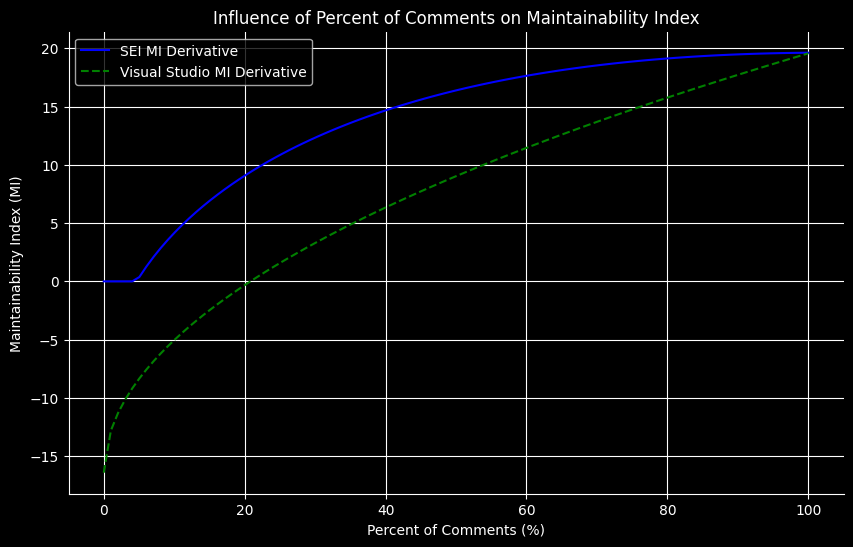

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Define the percentage of comments (as a range from 0% to 100%)
percent_comments = np.linspace(0, 100, 100)

# Define constants for the SEI and Visual Studio MI formulas
# These are placeholders; replace them with actual coefficients if available
V = 1000  # Cyclomatic complexity
G = 10   # Halstead effort
L = 10000  # Lines of code
C = percent_comments / 100  # Convert percentage to a fraction

# Compute the SEI MI derivative
MI_SEI = np.maximum(0, (171 - 5.2 * np.log(V) - 0.23 * G - 16.2 * np.log(L) + 50 * np.sin(np.sqrt(2.4 * C))) / 171 * 100)

# Compute the Visual Studio MI derivative (simplified version)
MI_VS = 171 - 5.2 * np.log(V) - 0.23 * G - 16.2 * np.log(L) + 36 * np.sqrt(C)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(percent_comments, MI_SEI, label="SEI MI Derivative", color="blue")
plt.plot(percent_comments, MI_VS, label="Visual Studio MI Derivative", color="green", linestyle="--")

# Add labels, title, and legend
plt.title("Influence of Percent of Comments on Maintainability Index")
plt.xlabel("Percent of Comments (%)")
plt.ylabel("Maintainability Index (MI)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [7]:
from pylint.reporters.base_reporter import BaseReporter

class ScoreOnlyReporter(BaseReporter):
    def __init__(self, output = None) -> None:
        super().__init__(output)
        self.name = "score-only"
    
    def handle_message(self, msg):
        pass

    def writeln(self, string = ""):
        pass

    def display_reports(self, layout):
        pass

    def on_close(self, stats, previous_stats): # type: ignore
        print(f"Global Note: {stats.global_note}")
        return stats.global_note

In [ ]:
from pylint.lint import Run
import os
import subprocess
from radon.metrics import mi_visit, h_visit
from radon.raw import analyze
import re

def get_maintainability_index(source_code, filepath='temp_code.py'):
    """
    Calculate the Maintainability Index of a given source code file.
    Args:
        source_code (str): The source code to analyze.
        filepath (str): The path to the file to save the source code temporarily.
    Returns:
        int: The Maintainability Index of the source code.
    """
    try:
        return int(mi_visit(source_code, True))
    except Exception as e:
        filename = filepath.split('/')[-1]
        with open(filename, "w") as f:
            f.write(source_code)
        result = subprocess.run(
            ['python2', '-m' 'radon', "mi", "-s", filename],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        maintainability_output = result.stdout
        match_mi = re.search(r"\((\d+)\)", maintainability_output)
        if match_mi:
            os.remove(filename)
            return int(match_mi.group(1))
        else:
            return 0
            raise Exception(f"File at {filepath} does not compile: {result.stderr}")
        
def get_pylint_score(source_code, filepath='temp_code.py'):
    filename = filepath.split("/")[-1]
    with open(filename, 'w') as f:
        f.write(source_code)
    try:
        pylint_results = Run([filename], ScoreOnlyReporter(), exit=False)
        os.remove(filename)
        return pylint_results.linter.stats.global_note
    except Exception as e:
        raise Exception(f"File at {filepath} does not compile: {e}")
    
class Python2LineMetics:
    def __init__(self, loc, lloc, sloc, comments, single_comments, multi, blank):
        self.loc = loc
        self.lloc = lloc
        self.sloc = sloc
        self.comments = comments
        self.single_comments = single_comments
        self.multi = multi
        self.blank = blank

    def __repr__(self):
        return f"LOC: {self.loc}, LLOC: {self.lloc}, SLOC: {self.sloc}, Comments: {self.comments}, Single Comments: {self.single_comments}, Multi: {self.multi}, Blank: {self.blank}"

def get_line_metrics(source_code, filepath='temp_code.py'):
    try:
        return analyze(source_code)
    except Exception as e:
        filename = filepath.split("/")[-1]
        with open(filename, 'w') as f:
            f.write(source_code)
        result = subprocess.run(
            ['python2', '-m' 'radon', "raw", filename],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        line_metrics_output = result.stdout
        loc = re.search(r"LOC:\s*(\d+)", line_metrics_output)
        lloc = re.search(r"LLOC:\s*(\d+)", line_metrics_output)
        sloc = re.search(r"SLOC:\s*(\d+)", line_metrics_output)
        comments = re.search(r"Comments:\s*(\d+)", line_metrics_output)
        single_comments = re.search(r"Single comments:\s*(\d+)", line_metrics_output)
        multi = re.search(r"Multi:\s*(\d+)", line_metrics_output)
        blank = re.search(r"Blank:\s*(\d+)", line_metrics_output)
        if loc and lloc and sloc and comments and single_comments and multi and blank:
            os.remove(filename)
            return Python2LineMetics(
                loc=int(loc.group(1)),
                lloc=int(lloc.group(1)),
                sloc=int(sloc.group(1)),
                comments=int(comments.group(1)),
                single_comments=int(single_comments.group(1)),
                multi=int(multi.group(1)),
                blank=int(blank.group(1))
            )
        else:
            raise Exception(f"File at {filepath} does not compile: {result.stderr}")
class Python2HelsteadTotal:
    def __init__(self, h1, h2, N1, N2):
        self.h1 = h1
        self.h2 = h2
        self.N1 = N1
        self.N2 = N2

class Python2HelsteadReport:
    def __init__(self, h1, h2, N1, N2):
        self.total = Python2HelsteadTotal(h1, h2, N1, N2)

    def __repr__(self):
        return f"""
        HelsteadReport(total: 
        h1={self.total.h1}, 
        h2={self.total.h2}, 
        N1={self.total.N1}, 
        N2={self.total.N2})"""

def get_halstead_metrics(source_code, filepath='temp_code.py'):
    """
    Calculate the Halstead metrics of a given source code file.
    Args:
        source_code (str): The source code to analyze.
        filepath (str): The path to the file to save the source code temporarily.
    Returns:
        dict: A dictionary containing the Halstead metrics.
    """
    try:
        return h_visit(source_code)
    except Exception as e:
        filename = filepath.split("/")[-1]
        with open(filename, 'w') as f:
            f.write(source_code)
        result = subprocess.run(
            ['python2', '-m' 'radon', "raw", filename],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        line_metrics_output = result.stdout
        theta_1 = re.search(r"h1:\s*(\d+)", line_metrics_output)
        theta_2 = re.search(r"h1:\s*(\d+)", line_metrics_output)
        N1 = re.search(r"N1:\s*(\d+)", line_metrics_output)
        N2 = re.search(r"N2:\s*(\d+)", line_metrics_output)
        
        if theta_1 and theta_2 and N1 and N2:
            os.remove(filename)
            return Python2HelsteadReport(
                h1=int(theta_1.group(1)),
                h2=int(theta_2.group(1)),
                N1=int(N1.group(1)),
                N2=int(N2.group(1))
            )
        else:
            return Python2HelsteadReport(
                h1=0,
                h2=0,
                N1=0,
                N2=0
            )
            raise Exception(f"File at {filepath} does not compile: {result.stderr}")


In [12]:
from pydriller import Repository
from datetime import datetime, timedelta
import pymongo

# Connect to MongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")

# Define the repository parameters
repo_name = "Resume-Matcher"
repo_path = f"/Users/as/Library/Mobile Documents/com~apple~CloudDocs/Dokumente/Studium/Bachelor-Thesis/tmp/{repo_name}"
end_date = datetime.now()
start_date = end_date - timedelta(days=6*365)

ocdb = myclient["OCEL"]

# Go through commits in the repository
# FIXME Instead of using snapshot, start with inital commit
python_files = set()
repository_code_metrics = dict()

# Snapshot of code quality for start of analysis
for commit in Repository(repo_path, since=start_date, only_modifications_with_file_types=[".py"], num_workers=1).traverse_commits():
    initial_commit = subprocess.run(['git', 'rev-parse', 'HEAD'], cwd=repo_path, stdout=subprocess.PIPE, text=True).stdout.strip()
    
    subprocess.run(['git', 'checkout', commit.hash], cwd=repo_path, check=True)
    result = subprocess.run(
        ["git", "ls-files", "*.py", "**/*.py"],
        cwd=repo_path,
        stdout=subprocess.PIPE,
        text=True,
        check=True
    )
    py_files = result.stdout.strip().split('\n')
    # Variant 1, check if simply passing the path is faster
    for file in py_files:
        try:
            with open(f"{repo_path}/{file}", 'r') as f:
                source_code = f.read()
        except Exception as e:
            print(f"Error reading file {file}: {e}")
        mi = get_maintainability_index(source_code)/100
        pl = get_pylint_score(source_code)/10
        repository_code_metrics[file] = [mi, pl]

    subprocess.run(['git', 'checkout', initial_commit], cwd=repo_path, check=True)
    break
    
for commit in Repository(repo_path, since=start_date, to=end_date, only_modifications_with_file_types=[".py"], num_workers=1).traverse_commits():
    file_mis = []
    file_pylints = []
    line_metrics = []
    helstead_metrics = []

    commit_mis = []
    commit_pylints = []

    # Go through modified files in the commit
    for modified_file in commit.modified_files:
        if modified_file.change_type.name == "ADD" and modified_file.new_path and modified_file.new_path.endswith(".py"):
            repository_code_metrics[modified_file.new_path] = [0, 0]
        elif modified_file.change_type.name == "DELETE" and modified_file.old_path and modified_file.old_path.endswith(".py"):
            repository_code_metrics.pop(modified_file.old_path, None)
            continue
        elif modified_file.change_type.name == "RENAME":
            if modified_file.old_path and modified_file.old_path.endswith(".py"):
                repository_code_metrics.pop(modified_file.old_path, None)
            if modified_file.new_path and modified_file.new_path.endswith(".py"):
                repository_code_metrics[modified_file.new_path] = [0, 0]
            if modified_file.source_code and modified_file.source_code_before:
                print(f"File LOC changed from {len(modified_file.source_code_before.split("\n"))} to {len(modified_file.source_code.split("\n"))}")
        elif modified_file.change_type.name == "MODIFY" and modified_file.new_path and modified_file.new_path.endswith(".py"):
            repository_code_metrics[modified_file.new_path] = [0, 0]
        else:
            continue
        
        if modified_file.new_path is None or modified_file.new_path.endswith(".py") == False:
            continue
        # Calculate code quality metrics
        # TODO Optimize by not analyzing files that are renamed
        if modified_file.source_code is None:
            source = ""
            print(f"File {modified_file.new_path} has no source code")
        else:
            source = modified_file.source_code
        mi = get_maintainability_index(source)/100
        pl = get_pylint_score(source)/10
        file_mis.append(mi)
        file_pylints.append(pl)

        repository_code_metrics[modified_file.new_path] = [mi, pl]

        line_metrics.append(get_line_metrics(source))
        helstead_metrics.append(get_halstead_metrics(source))

        # Create a dictionary for the commit
        type = "commit"
    for k,v in repository_code_metrics.items():
        commit_mis.append(v[0])
        commit_pylints.append(v[1])
    commit_mi = sum(commit_mis)/len(commit_mis) if commit_mis else 0
    commit_pylint = sum(commit_pylints)/len(commit_pylints) if commit_pylints else 0
    commit_dict = {
        "commit_date": commit.committer_date,
        "commit_author": commit.author.name,
        "commit_message": commit.msg,
        "commit_mi": commit_mi,
        "commit_pylint": commit_pylint,
        "commit_loc": sum([lm.loc for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_lloc": sum([lm.lloc for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_sloc": sum([lm.sloc for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_comments": sum([lm.comments for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_single_comments": sum([lm.single_comments for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_multi": sum([lm.multi for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_blank": sum([lm.blank for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_h1": sum([hm.total.h1 for hm in helstead_metrics])/len(helstead_metrics) if helstead_metrics else 0,
        "commit_h2": sum([hm.total.h2 for hm in helstead_metrics])/len(helstead_metrics) if helstead_metrics else 0,
        "commit_N1": sum([hm.total.N1 for hm in helstead_metrics])/len(helstead_metrics) if helstead_metrics else 0,
        "commit_N2": sum([hm.total.N2 for hm in helstead_metrics])/len(helstead_metrics) if helstead_metrics else 0,
    }
    ocdb[repo_name].replace_one({"_id": commit.hash}, {"type": type, "attributes": commit_dict}, upsert=True)

Previous HEAD position was 0b39f8c Updated version (#264)
HEAD is now at 3071e17 Updating Progress


Global Note: 0


Previous HEAD position was 3071e17 Updating Progress
HEAD is now at 0b39f8c Updated version (#264)


File Progress/Keywords.py has no source code
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
File Progress/first_app.py has no source code
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
Global Note: 0
File Progress/Archived Code/app.py has no source code
Global Note: 0
File Progress/Archived Code/compute.py has no source code
Global Note: 0
File Progress/Archived Code/generate_wordcloud.py has no source code
Global Note: 0
File LOC changed from 48 to 48
Global Note: 0
Global Note: 0
File Cleaner.py has no source code
Global Note: 0
File Distill.py has no source code
Global Note: 0
File Similar.py has no source code
Global Note: 0
File app2.py has no source code
Global Note: 0
File fileReader.py h

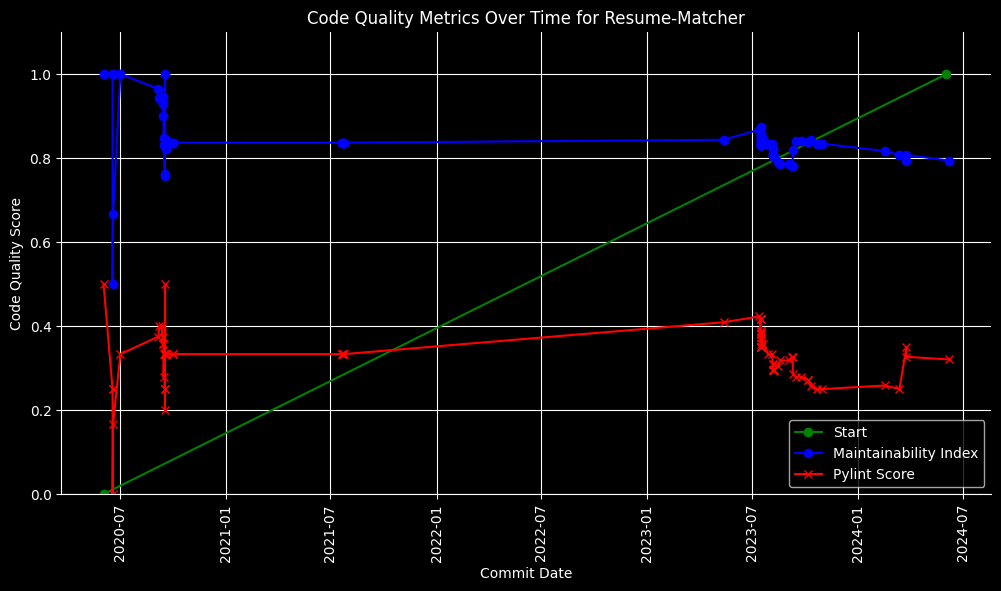

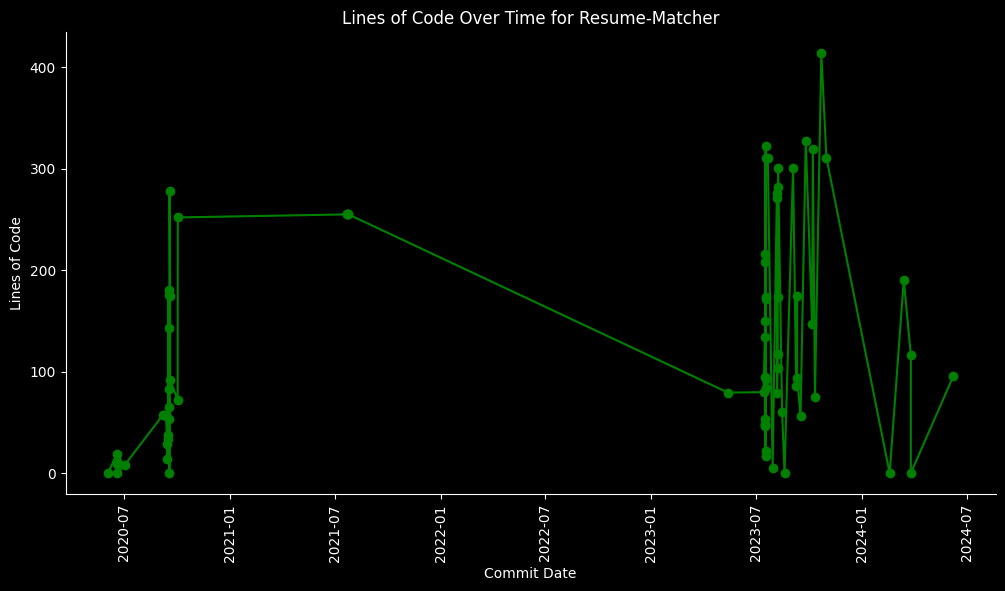

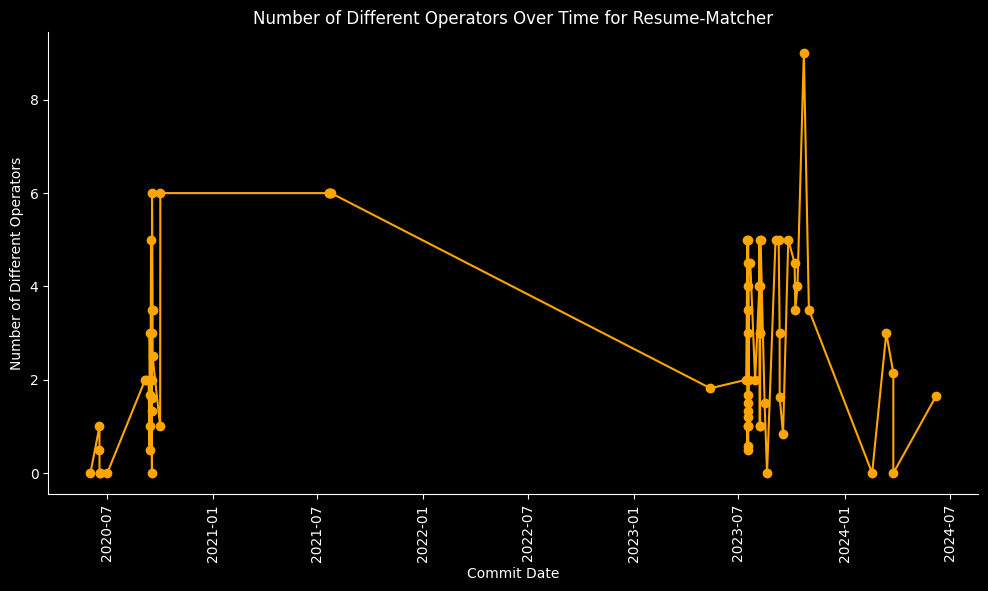

In [13]:
import pymongo
# Connect to MongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")

# Define the repository parameters
repo_path = f"/Users/as/Library/Mobile Documents/com~apple~CloudDocs/Dokumente/Studium/Bachelor-Thesis/tmp/{repo_name}"


ocdb = myclient["OCEL"]
from matplotlib import pyplot as plt
import numpy as np
collection = ocdb[repo_name]
# Query the data
data = collection.find({"type": "commit"}, {"attributes.commit_date": 1, "attributes.commit_mi": 1, "attributes.commit_pylint": 1, "attributes.commit_loc": 1, "attributes.commit_h1": 1, "attributes.commit_n2": 1, "attributes.commit_N1": 1, "attributes.commit_N2": 1}).sort("attributes.commit_date", pymongo.ASCENDING)

# Extract commit_dates and maintainability indices
commit_dates = []
maintainability_indices = []

commit_pylints = []
commit_locs = []
commit_n1s = []

for record in data:
    if "attributes" in record:
        attributes = record["attributes"]
        if "commit_date" in attributes and "commit_mi" in attributes and "commit_pylint" in attributes and "commit_loc" in attributes and "commit_h1" in attributes:
            commit_dates.append(attributes["commit_date"])
            maintainability_indices.append(attributes["commit_mi"])
            commit_pylints.append(attributes["commit_pylint"])
            commit_locs.append(attributes["commit_loc"])
            commit_n1s.append(attributes["commit_h1"])
        else:
            print(f"Missing data in attributes: {attributes}")
    else:
        print(f"Missing attributes in record: {record}")

sorted_mis = sorted(zip(commit_dates, maintainability_indices), key=lambda x: x[0])
sorted_pylints = sorted(zip(commit_dates, commit_pylints), key=lambda x: x[0])
sorted_locs = sorted(zip(commit_dates, commit_locs), key=lambda x: x[0])
sorted_n1s = sorted(zip(commit_dates, commit_n1s), key=lambda x: x[0])
commit_dates, maintainability_indices = zip(*sorted_mis)
commit_dates, commit_pylints = zip(*sorted_pylints)
commit_dates, commit_locs = zip(*sorted_locs)
commit_dates, commit_n1s = zip(*sorted_n1s)

date_str = "2020-06-02T19:45:54.000+00:00"
date_obj_1 = datetime.fromisoformat(date_str.replace("Z", "+00:00"))
date_obj_2 = datetime.fromisoformat(date_str.replace("020", "024"))
dt = np.array([date_obj_1, date_obj_2])
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(dt, [0, 1], label="Start", color="green", marker="o")
plt.plot(commit_dates, maintainability_indices, label="Maintainability Index", color="blue", marker="o", linestyle="-")
plt.plot(commit_dates, commit_pylints, label="Pylint Score", color="red", marker="x", linestyle="-")
plt.xlabel("Commit Date")
plt.ylabel("Code Quality Score")
plt.title(f"Code Quality Metrics Over Time for {repo_name}")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.ylim(0, 1.1)
plt.grid()
plt.legend()
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(commit_dates, commit_locs, label="Lines of Code", color="green", marker="o", linestyle="-")
plt.xlabel("Commit Date")
plt.ylabel("Lines of Code")
plt.title(f"Lines of Code Over Time for {repo_name}")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(commit_dates, commit_n1s, label="Number of Different Operators", color="orange", marker="o", linestyle="-")
plt.xlabel("Commit Date")
plt.ylabel("Number of Different Operators")
plt.title(f"Number of Different Operators Over Time for {repo_name}")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.xticks(rotation=90)
plt.show()